### N-Gram Language Model

This notebook will train country and a heavy metal ngram models for the given NGRAM value. It generates and prints sequences using these models as well as evaluates perplexity on the validation sets. Analysis of tuning the NGRAM value can be found at the bottom of the notebook. 

When running, NGRAM (the n value to use) and NUM_SEQ_TO_GENERATE (the number of new sequences to create with the trained model) can be adjusted. 

In [223]:
#imports 
import pandas as pd
import ngram_laplace_lm_model as lm
import numpy as np
import matplotlib.pyplot as plt

import utils 

In [224]:
# special tokens 
SENTENCE_BEGIN = "<s>"
SENTENCE_END = "</s>"

# filepaths 
country_train_filepath = "data/country_train.csv"
country_val_filepath = "data/country_val.csv"
country_test_filepath = "data/country_test.csv"

metal_train_filepath = "data/metal_train.csv"
metal_val_filepath = "data/metal_val.csv"
metal_test_filepath = "data/metal_test.csv"

# constants to change 
NGRAM = 4
NUM_SEQ_TO_GENERATE = 10 # how many lines to generate with our models 
VERBOSE = True

In [251]:
# read in data
country_train_lyrics = pd.read_csv(country_train_filepath, header=None)[0].to_list()
country_val_lyrics = pd.read_csv(country_val_filepath, header=None)[0].to_list()
country_test_lyrics = pd.read_csv(country_test_filepath, header=None)[0].to_list()
print("Number of training lines for Country:", len(country_train_lyrics))
print("Number of validation lines for Country:", len(country_val_lyrics))
print("Number of test lines for Country:", len(country_test_lyrics))
print()

metal_train_lyrics = pd.read_csv(metal_train_filepath, header=None)[0].to_list()
metal_val_lyrics = pd.read_csv(metal_val_filepath, header=None)[0].to_list()
metal_test_lyrics = pd.read_csv(metal_test_filepath, header=None)[0].to_list()
print("Number of training lines for Heavy Metal:", len(metal_train_lyrics))
print("Number of validation lines for Heavy Metal:", len(metal_val_lyrics))
print("Number of test lines for Heavy Metal:", len(metal_test_lyrics))

Number of training lines for Country: 149771
Number of validation lines for Country: 18610
Number of test lines for Country: 19108

Number of training lines for Heavy Metal: 149771
Number of validation lines for Heavy Metal: 18610
Number of test lines for Heavy Metal: 19108


In [226]:
def create_ngram_laplace_model(training_sequences: list, ngram: int = NGRAM, verbose: bool = True):
	"""
	 Creates a trained n-gram language model using Laplace Smoothing using the given training data 

	 Args:
		training_sequences (list): a list of training sequence strings
		ngram (int): the n-gram order of the language model to create
		verbose (bool): if True, prints information about the training data 

	Returns:
		A trained NGramLaplaceLanguageModel
	"""
	tokens = utils.tokenize(training_sequences, ngram)
	model = lm.NGramLaplaceLanguageModel(ngram)
	model.train(tokens, verbose=verbose)

	return model

In [227]:
print("Country Laplace Model:")
laplace_country_model = create_ngram_laplace_model(country_train_lyrics)

Country Laplace Model:
Number of tokens: 2099943
N-gram examples: [('<s>', '<s>', '<s>', 'i'), ('<s>', '<s>', 'i', "'ve"), ('<s>', 'i', "'ve", 'seen')]
Vocabulary Size: 11236


In [228]:
print("Heavy Metal Laplace Model:")
laplace_metal_model = create_ngram_laplace_model(metal_train_lyrics)

Heavy Metal Laplace Model:
Number of tokens: 1846891
N-gram examples: [('<s>', '<s>', '<s>', 'my'), ('<s>', '<s>', 'my', 'journey'), ('<s>', 'my', 'journey', 'began')]
Vocabulary Size: 14350


#### Generate New Sequences 

In [229]:
# method to help format generated sentences 
def clean_lyric(lyric_tokens: list) -> str:
    """
    Return the given sequence of tokens as a single string without special tokens 
    Args:
        lyric_tokens (list): list of tokens for the generated sequence

    Returns:
        The tokens joined in a single string without special characters 

    """
    lyric_str = ' '.join(lyric_tokens)
    return lyric_str.replace(SENTENCE_BEGIN, '').replace(SENTENCE_END, '').strip()

In [244]:
print("Country Generated Lyrics:\n")
for i in range(NUM_SEQ_TO_GENERATE):
    lyric_tokens = laplace_country_model.generate_sentence()
    print(clean_lyric(lyric_tokens))

Country Generated Lyrics:

( peace on earth tonight
c/g f em
tell you the truth , my friend
so sad but so true
lets love like we 're hungry again
caught this ramblin ' fever in my head from my toes
talk about a bummer
i ( c ) king is ( g ) floor
to the one he wanted
and that funeral  well it wad n't much for looks he was only five feet tall


In [243]:
for l in country_train_lyrics:
    if "yeah, you're crying" in l:
        print(l)

In [231]:
print("Heavy Metal Generated Lyrics:\n")
for i in range(NUM_SEQ_TO_GENERATE):
    lyric_tokens = laplace_metal_model.generate_sentence()
    print(clean_lyric(lyric_tokens))

Heavy Metal Generated Lyrics:

give up your life ,
their humility
i cry aloud my last words of sorrow
on velvet skins
better to die than to live with sure body wild until the pressure so
to fight our souls with silent screams
just remember , remember
i tried to run , the tale is black , all we have is real
true and faithful
i will tell you


#### Evaluate Perplexity

We will compute the mean perplexity on the validation data, which is distinct from the data used to train the model

In [250]:
def get_perplexities(model, lines: list, ngram: int=NGRAM):
    """
    Finds the mean perplexity for each of the given test sequences using the given model

    Args:
        model : the  N-gram Language Model 
        lines (list): a list of strings of data to evaluate perplexity on 
        ngram (int): the n-gram order used by the model
       
    Returns: 
        perplexities (list): list of perplexity values 
    """
    perplexities = []
    for line in lines:
        test_tokens = utils.tokenize_line(line, ngram)
        perplexities.append(model.perplexity(test_tokens))

    return perplexities


def average_perplexity(model, lines: list, ngram: int=NGRAM): 
    """
    Evaluates the given model by finding the mean perplexity of the given test sequences. 

    Args:
        model : the  N-gram Language Model 
        lines (list): a list of strings of data to evaluate perplexity on 
        ngram (int): the n-gram order used by the model
        
    Returns: average perplexity over the given sequences 
    """
    perplexities = get_perplexities(model, lines, ngram)
    return np.mean(perplexities)


print("NGRAM =", NGRAM)

print("Mean Validation Perplexity for Country Model:", average_perplexity(laplace_country_model, country_val_lyrics))
print("Mean Validation Perplexity for Heavy Metal Model:", average_perplexity(laplace_metal_model, metal_val_lyrics))

NGRAM = 4
Mean Validation Perplexity for Country Model: 2536.2361611565543
Mean Validation Perplexity for Heavy Metal Model: 3727.8271978820085


### Experimentation - Testing out Different NGRAM values

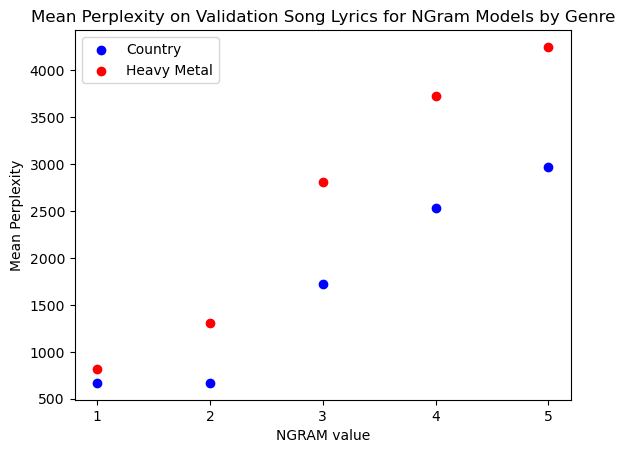

In [248]:
# visualize how NGRAM value impacts perplexity

# NGRAM value for our x-axis 
ngram_values = [1, 2, 3, 4, 5]
plt.xticks(ngram_values, ngram_values)

# Mean Validation Perplexities for y-axis - rounded to the nearest integer 
val_perplexities_country = [672, 669, 1722, 2536, 2970]
val_perplexities_metal = [813, 1309, 2811, 3728, 4249]

plt.scatter(ngram_values, val_perplexities_country, color='blue', label='Country')
plt.scatter(ngram_values, val_perplexities_metal,  color='red', label='Heavy Metal')

plt.xlabel('NGRAM value')
plt.ylabel('Mean Perplexity')
plt.title('Mean Perplexity on Validation Song Lyrics for NGram Models by Genre')
plt.legend()
plt.show()

| NGRAM | Genre       | Mean Validation Perplexity | Generated Examples                                                                                                                                                                                     |
|-------|-------------|----------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1     | Country     | 671.6781087727638          | our days well<br>glory<br>until<br>, marie sound it of i american<br>they the if both through antone lose<br>to you waiting river new you                                                              |
| 2     | Country     | 669.3040625824256          | love , oh wipe each other one without wishin that 's the by<br>except what to realize<br>put you take you<br>he loved her mother<br>no chance                                                          |
| 3     | Country     | 1722.161449942283          | i said i will<br>and little jeanie 's sake .<br>technicolor , river queen , three on high<br>when a road with my fiddle<br>yes everything i have shown                                                 |
| 4     | Country     | 2536.2361611565543         | if heaven 's real<br>i do n't know<br>one night at a time<br>well you nursed me through the valley filled with snow<br>we always wear a great big world are we<br>on a cloud nine ride                 |
| 5     | Country     | 2970.185882071465          | lord above me knows i love you<br>i get along with you<br>however you look at it , whatever you believe<br>she can crawl it<br>'cause it 's beer thirty , and it 's time to go out on a huntin ' spree |
| 1     | Heavy Metal | 813.055866023289           | ends a - was you<br>ice me go<br>there , was without watch my<br>fears an the of left give blood drive-in state power<br>is far hate the fever can ear again who face                                  |
| 2     | Heavy Metal | 1309.2450258437107         | out all you<br>but i hide , hey , dokken ,<br>lay you pain<br>colder than you make me in fire<br>learning life go                                                                                      |
| 3     | Heavy Metal | 2810.7121869637062         | oppressions wall they will learn<br>mad magicians tinsel nightmares<br>a thousand young<br>wherever you are too much abuse of wasted human ... debris<br>turning bottled water into wine               |
| 4     | Heavy Metal | 3727.8271978820085         | but now we retaliate<br>devoid the fake with full disdain<br>boiling in rage - sophisticated cage<br>well , i know<br>you feel it                                                                      |
| 5     | Heavy Metal | 4249.127826808508          | and now i close the door<br>you will forger the pain<br>ca n't somebody tell me am i the top of the chain<br>just be my human hand<br>death from above                                                 |


Based on the validation perplexities and our own evaluation of how comprehensible the models' outputs are, we selected an NGRAM value of 4. We want the NGRAM value to be large enough to capture context and grammatical-correctness over a sequence. However, but we don't want the NGRAM value to be too large, as this will cause our generated sentences to be mimicked from the training data (since Shannon's method only produces seen n-grams, and song lyrics can sometimes be short). With our chosen NGRAM value, some sequences may be parroted, but we hope that we will generally produce varied and understandable sequences.

In [234]:
def write_generated_seqs(model, num_seqs, file_path):
		"""" 
		Generates num_seqs lines with the given model and writes them to a txt file at the given file_path

		Args: 
			model : an N-gram model to generated sentences with 
			num_seqs (int): the number of lines to generate and save 
			file_path (str): the filepath to write to
		"""
		with open(file_path, 'w') as f:

			for i in range(num_seqs):
				# print progress 
				if i % 10 == 0:
					print("Generating line", i, "/", num_seqs)

				lyric_tokens = model.generate_sentence()
				f.write(clean_lyric(lyric_tokens)+ '/n')

		f.close()

# commenting out to avoid overwriting our files 
#write_generated_seqs(laplace_country_model, 100, "generated_txts/ngram_country.txt")
#write_generated_seqs(laplace_metal_model, 100, "generated_txts/ngram_metal.txt")

#### Compute Mean Perplexity on the Test Data for our Chosen Model (NGRAM = 4)

In [252]:
print("Mean Test Perplexity for Country Model:", average_perplexity(laplace_country_model, country_test_lyrics))
print("Mean Test Perplexity for Heavy Metal Model:", average_perplexity(laplace_metal_model, metal_test_lyrics))

Mean Test Perplexity for Country Model: 2507.3260001607314
Mean Test Perplexity for Heavy Metal Model: 3818.615241097852
